# Google Landmark Retrieval 2020
![Image](https://i.ibb.co/McK51WV/thomas-kelley-ncy-Dc3s-CR-s-unsplash.jpg)

## About this competition 
Image retrieval is a fundamental problem in computer vision: given a query image, can you find similar images in a large database? This is especially important for query images containing landmarks, which accounts for a large portion of what people like to photograph.
<br> 
In this competition, the developed models are expected to retrieve relevant database images to a given query image (ie, the model should retrieve database images containing the same landmark as the query).
<br>
"Content-based" means that the search analyzes the contents of the image rather than the metadata such as keywords, tags, or descriptions associated with the image. The term "content" in this context might refer to colors, shapes, textures, or any other information that can be derived from the image itself. CBIR is desirable because searches that rely purely on metadata are dependent on annotation quality and completeness.
<br>
Having humans manually annotate images by entering keywords or metadata in a large database can be time consuming and may not capture the keywords desired to describe the image. The evaluation of the effectiveness of keyword image search is subjective and has not been well-defined. In the same regard, CBIR systems have similar challenges in defining success. "Keywords also limit the scope of queries to the set of predetermined criteria." and, "having been set up" are less reliable than using the content itself.
<br><br>

## About this Notebook
In this kernel, I will briefly explain the structure of dataset. Then, I will visualize the dataset using Matplotlib and seaborn to gain as much insight as I can . Also I will approach this problem to provide a baseline solution and keep updating the kernel.

**This kernel is a work in Progress,and I will keep on updating it as the competition progresses and I learn more and more things about the data**

 <span style="color:red">If you find this kernel useful, Please Upvote it , it motivates me to write more Quality content</span>.

## Importing Necessary files

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2
import numpy as np

## Reading the data

In [2]:
os.listdir('../input/landmark-retrieval-2020')

['train.csv', 'index', 'train', 'test']

In [3]:
train_data = pd.read_csv('../input/landmark-retrieval-2020/train.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.1+ MB


In [5]:
# Getting image paths
train_paths = glob.glob('../input/landmark-retrieval-2020/train/*/*/*/*')
test_paths = glob.glob('../input/landmark-retrieval-2020/test/*/*/*/*')
index_paths = glob.glob('../input/landmark-retrieval-2020/index/*/*/*/*')

In [6]:
print(f'[INFO] No. of Index Images : {len(index_paths)}')
print(f'[INFO] No. of Train Images : {len(train_paths)}')
print(f'[INFO] No. of Test Images : {len(test_paths)}')

[INFO] No. of Index Images : 76176
[INFO] No. of Train Images : 1580470
[INFO] No. of Test Images : 1129


## EDA

In [7]:
train_data.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [8]:
train_data.describe()

,landmark_id
count,1.580470e+06
mean,1.015764e+05
std,5.878822e+04
min,1.000000e+00
25%,4.976600e+04
50%,1.021080e+05
75%,1.523310e+05
max,2.030920e+05


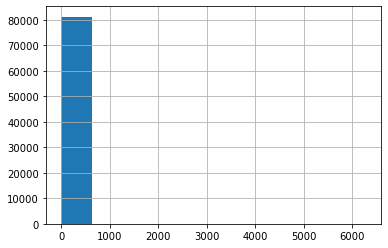

In [9]:
train_data['landmark_id'].value_counts().hist()

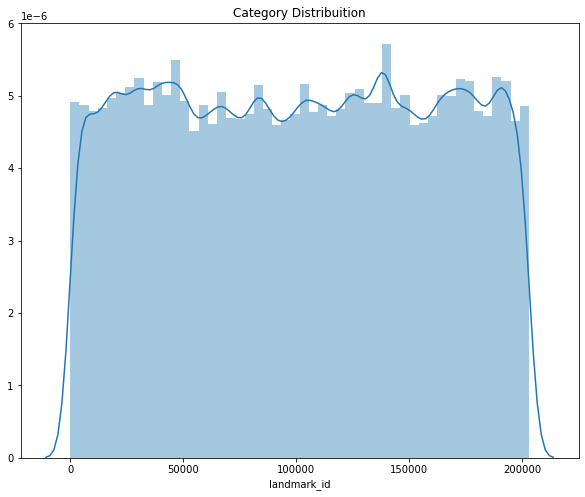

In [10]:
# Landmark ID distribution
plt.figure(figsize = (10, 8))
plt.title('Category Distribuition')
sns.distplot(train_data['landmark_id'])
plt.show()

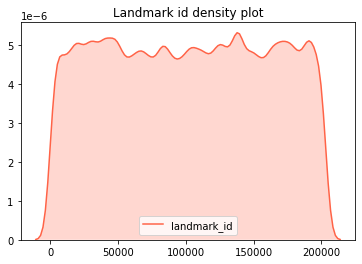

In [11]:
# Simple landmark id density plot
plt.title('Landmark id density plot')
sns.kdeplot(train_data['landmark_id'], color="tomato", shade=True)
plt.show()

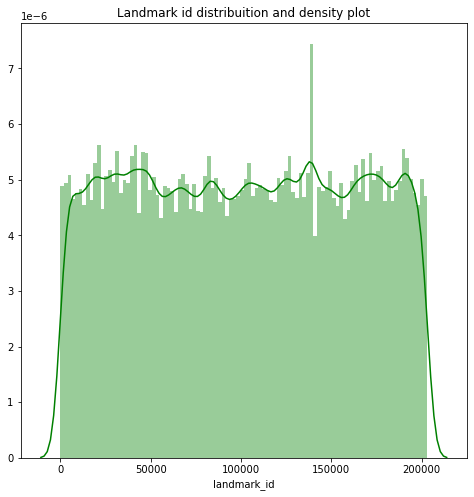

In [12]:
# Landmark Id distribution and density plot 
plt.figure(figsize = (8, 8))
plt.title('Landmark id distribuition and density plot')
sns.distplot(train_data['landmark_id'],color='green', kde=True,bins=100)
plt.show()

In [13]:
# Cheking for null values if any
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
landmark_id,0,0.0
id,0,0.0


In [14]:
# Occurance of landmark_id in decreasing order(Top categories)
temp = pd.DataFrame(train_data.landmark_id.value_counts().head(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,138982,6272
1,126637,2231
2,20409,1758
3,83144,1741
4,113209,1135
5,177870,1088
6,194914,1073
7,149980,971


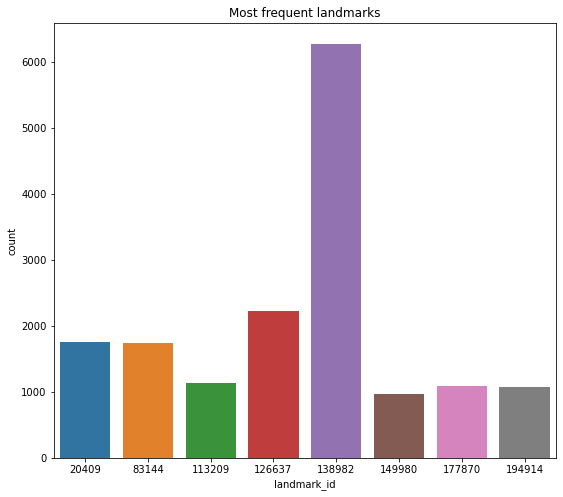

In [15]:
# Plot the most frequent landmark_ids
plt.figure(figsize = (9, 8))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

In [16]:
# Occurance of landmark_id in increasing order(Top categories)
temp = pd.DataFrame(train_data.landmark_id.value_counts().tail(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,4171,2
1,73532,2
2,195143,2
3,180503,2
4,179834,2
5,183115,2
6,63266,2
7,197219,2


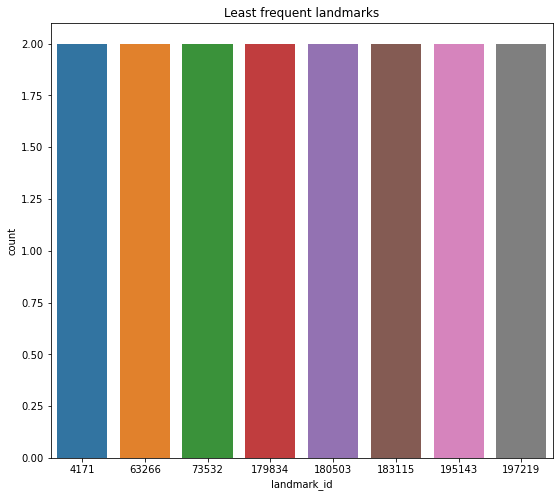

In [17]:
plt.figure(figsize = (9, 8))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

In [18]:
# uniques values in train 
train_data.nunique()

id             1580470
landmark_id      81313
dtype: int64

## Visualizing Images 

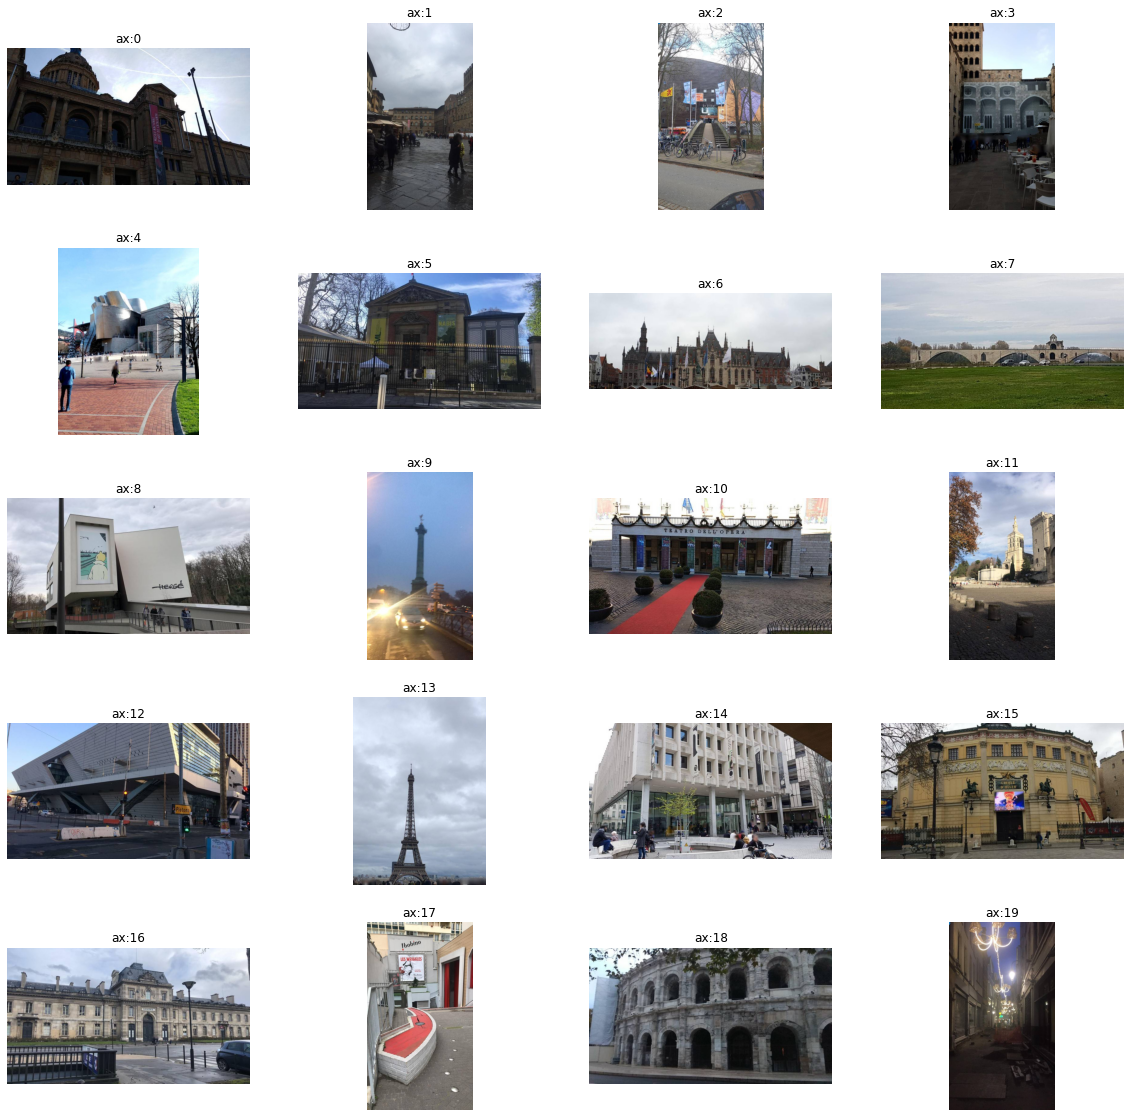

In [19]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 5

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    example = cv2.imread(test_paths[i])
    img = example[:,:,::-1]
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.axis('off')
    plt.imshow(img)

# do extra plots on selected axes/subplots
# note: index starts with 0
ax[2].plot(xs, 3*ys)
ax[19].plot(ys**2, xs)

plt.show()  # finally, render the plot